In [1]:
# only adjust settings in this cell
state = 'NM' 
year = 2020
enumeration_limit = 10

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json
from epsilon_constraint import*
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of NM has 3 districts.


In [5]:
from optimization import iterative_refinement
from math import ceil, floor
import time

deviation = 1/2
max_deviation = 0.01 * ideal_population
plans = list()

while True:

    print("*****************************************")
    print(f"Trying deviation = {deviation}.")
    print("*****************************************")
    
    L = ceil( ideal_population - deviation )
    U = floor( ideal_population + deviation )

    start_time = time.perf_counter()
    plans += iterative_refinement(G, L, U, G._k, state, enumeration_limit=enumeration_limit, verbose=False)
    print("Total time =",round(time.perf_counter() - start_time,2))

    if deviation == max_deviation:
        break
    
    deviation *= 2
    deviation = min( deviation, max_deviation )
       

*****************************************
Trying deviation = 0.5.
*****************************************
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
Total time = 0.23
*****************************************
Trying deviation = 1.0.
*****************************************
Total time = 95.45
*****************************************
Trying deviation = 2.0.
*****************************************
Total time = 68.97
*****************************************
Trying deviation = 4.0.
*****************************************
Total time = 67.8
*****************************************
Trying deviation = 8.0.
*****************************************
Total time = 44.4
*****************************************
Trying deviation = 16.0.
*****************************************
Total time = 33.17
*****************************************
Trying deviation = 32.0.
*****************************************

***************************************
obj_type = cut_edges
***************************************
Pareto front objective values: [[1354.3333333333721, 21], [1354.3333333333721, 21], [1510.6666666666279, 20], [3012.333333333372, 19], [3735.333333333372, 18], [5433.333333333372, 17]]


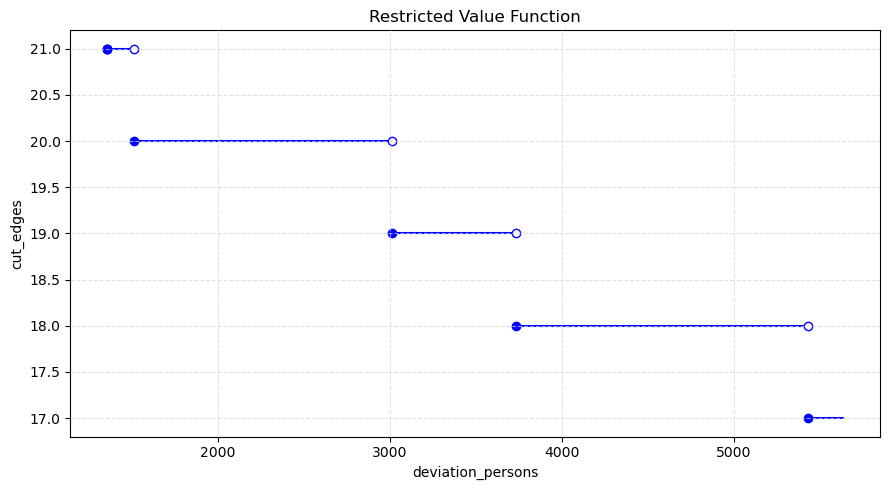

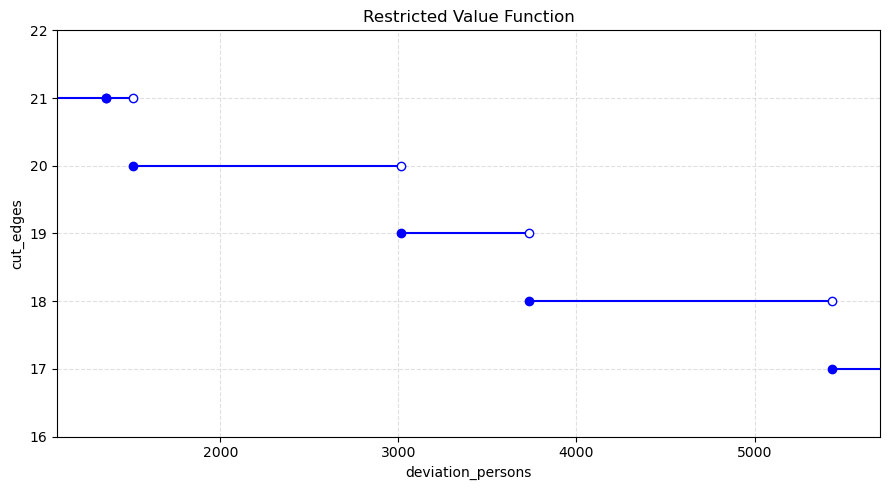

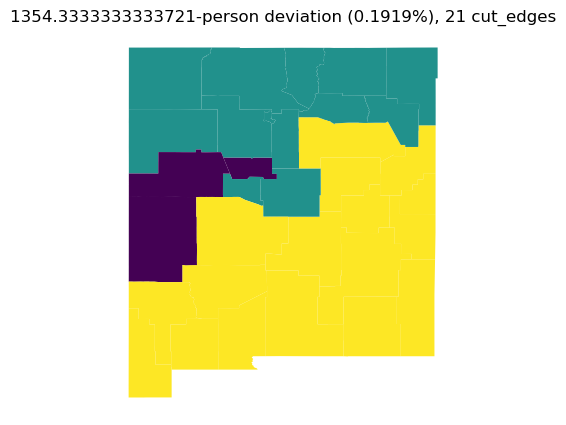

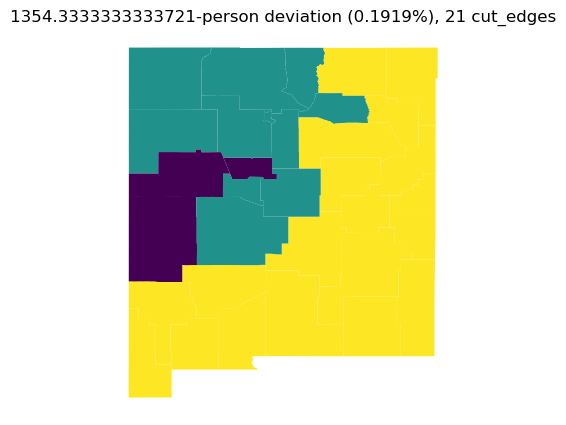

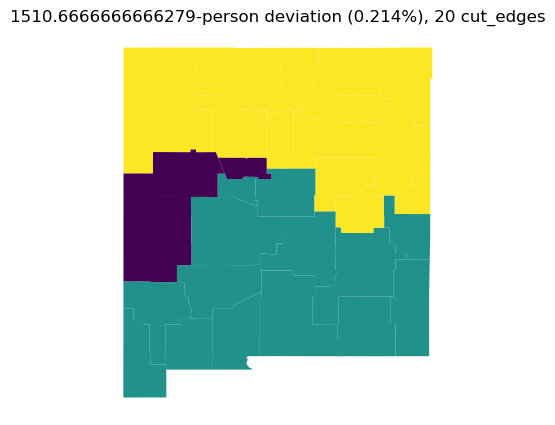

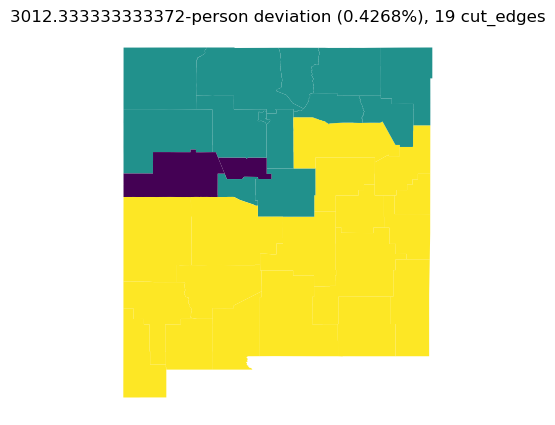

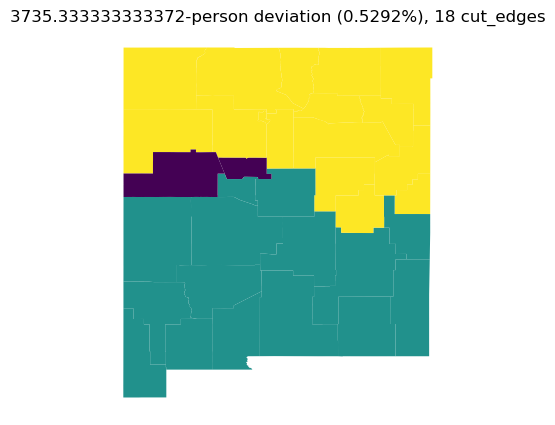

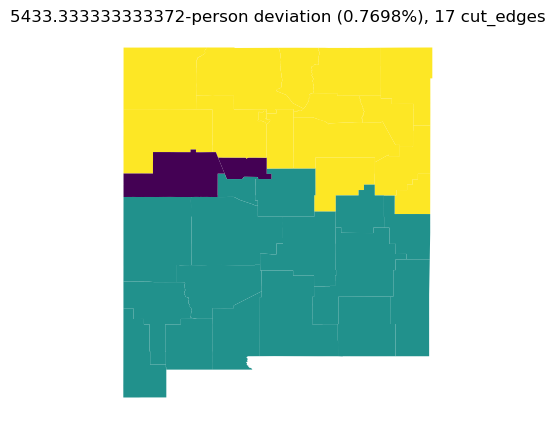

***************************************
obj_type = perimeter
***************************************
Pareto front objective values: [[1354.3333333333721, 55.50700622138527], [1510.6666666666279, 50.98912311192004], [3208.666666666628, 50.18372373556686], [3735.333333333372, 47.839336969480144], [5433.333333333372, 47.033937593126964]]


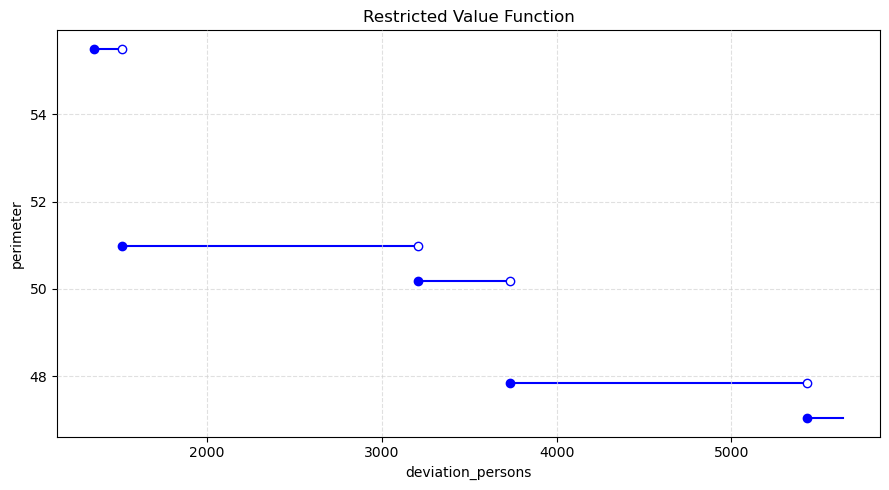

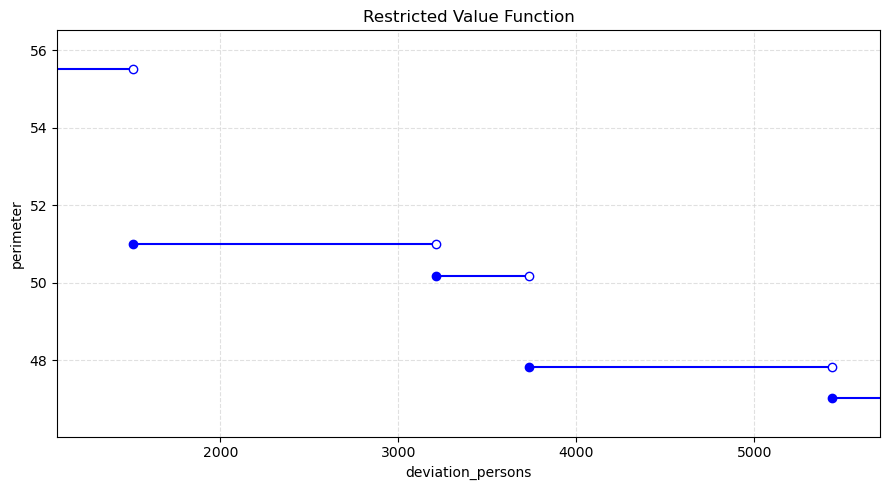

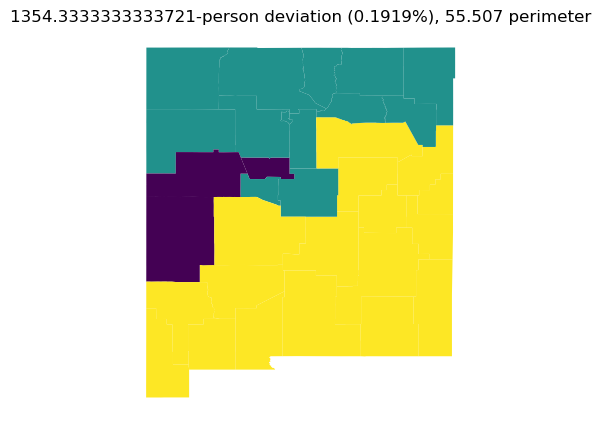

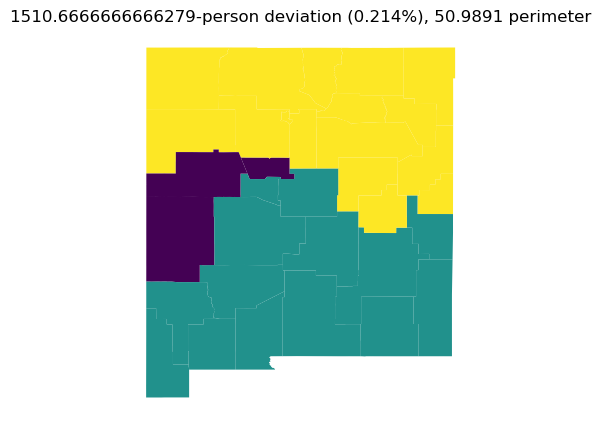

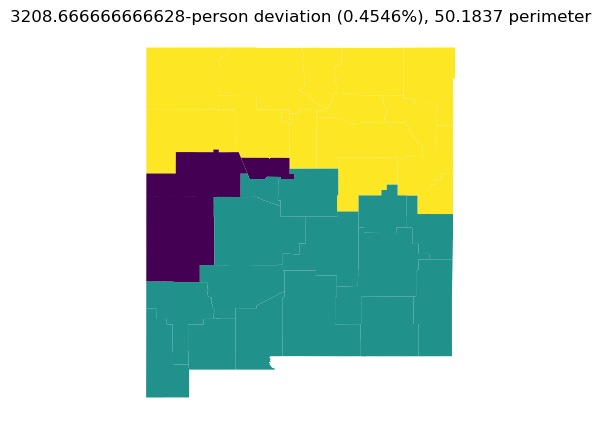

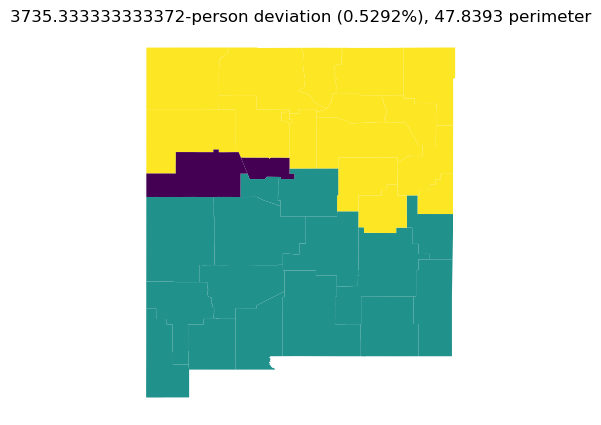

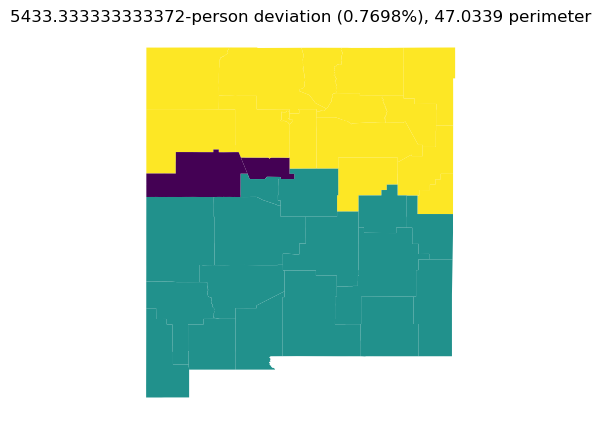

***************************************
obj_type = inverse_Polsby_Popper
***************************************
Pareto front objective values: [[1354.3333333333721, 2.8674776231990404], [1510.6666666666279, 2.4165485913761793], [3208.666666666628, 2.359282893226306], [5433.333333333372, 2.351294685741632]]


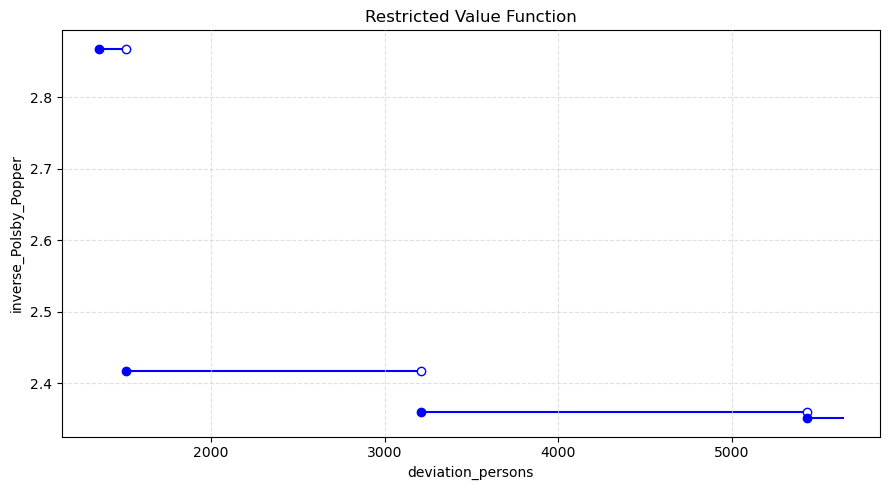

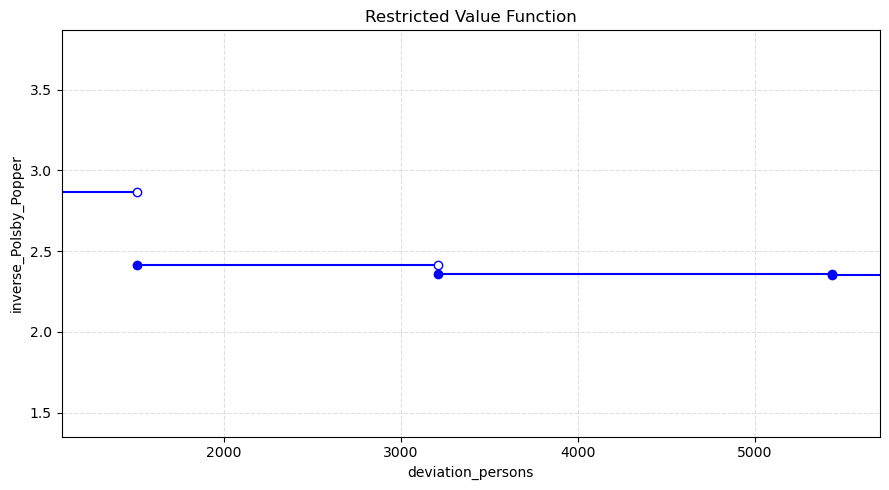

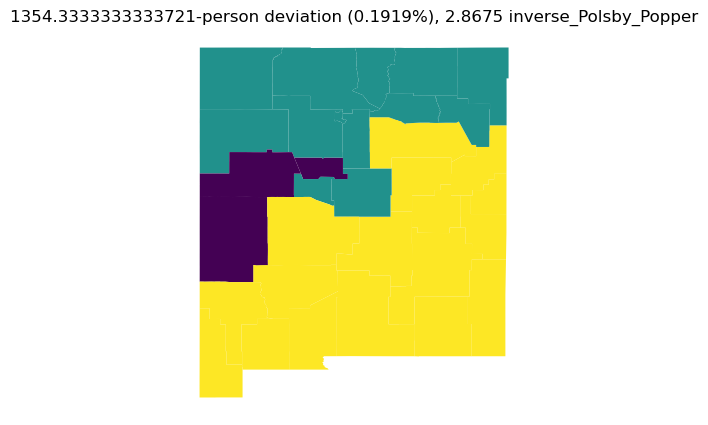

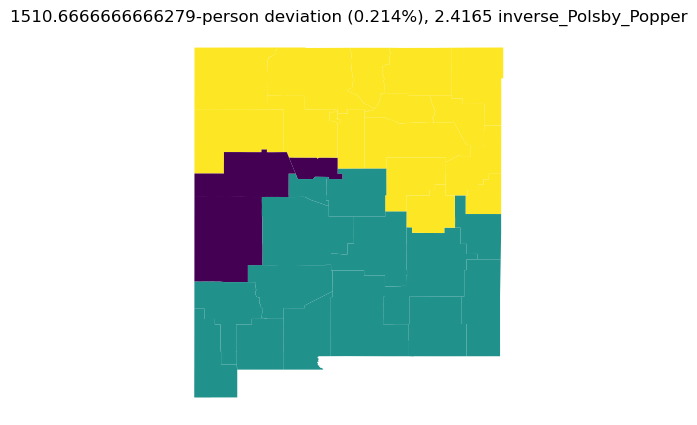

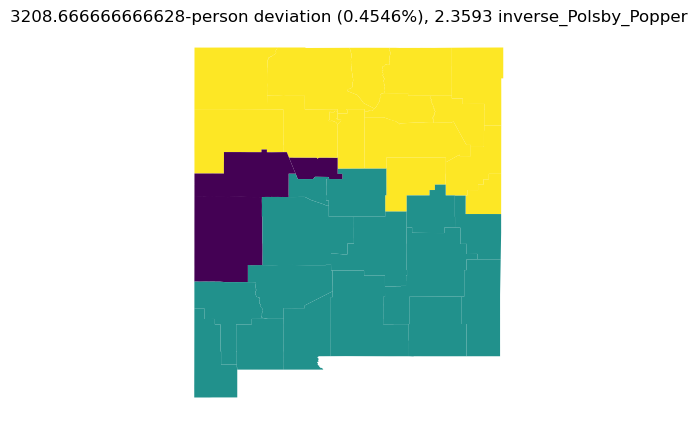

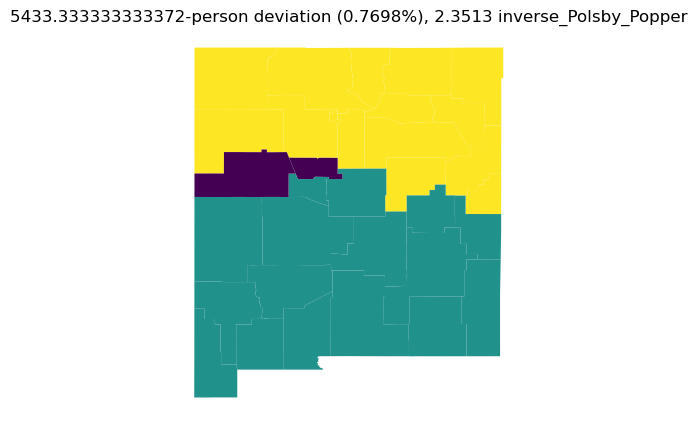

***************************************
obj_type = average_Polsby_Popper
***************************************
Pareto front objective values: [[1354.3333333333721, 0.3567720294858953], [1510.6666666666279, 0.415501415678718], [3208.666666666628, 0.42576644748134873], [5433.333333333372, 0.43342041766639655]]


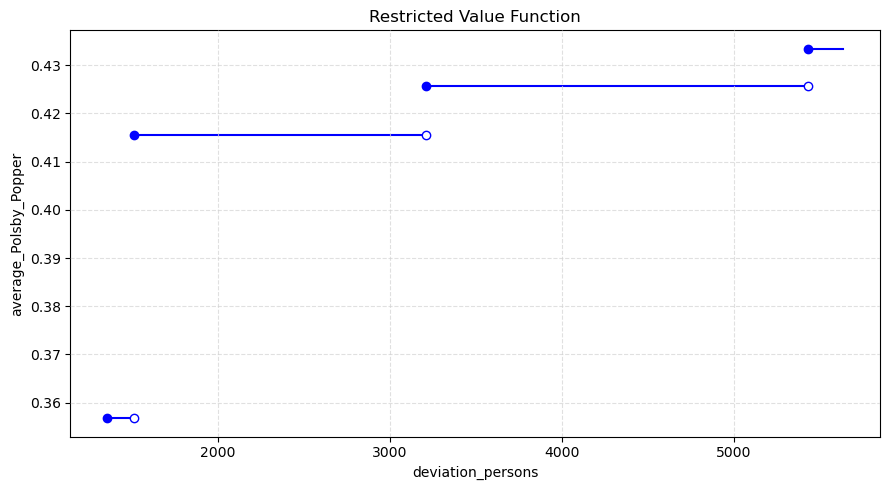

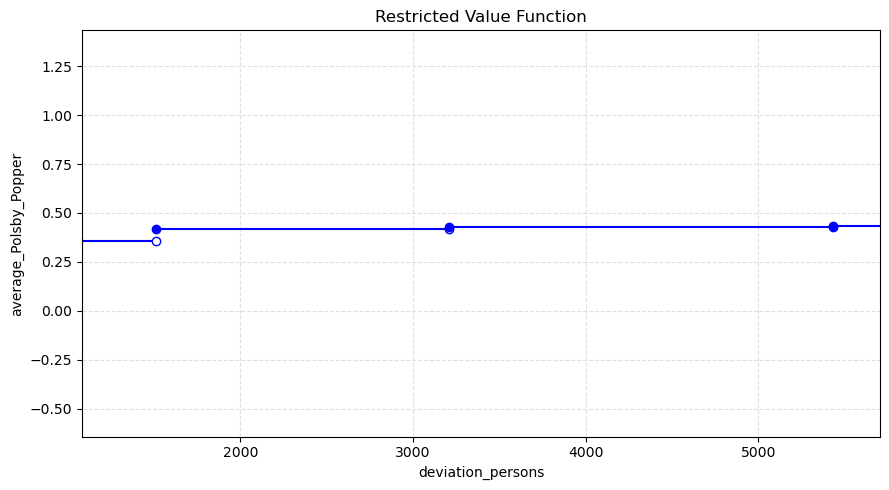

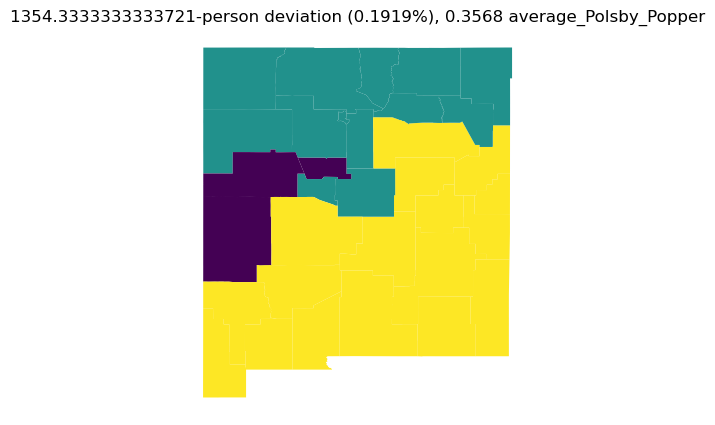

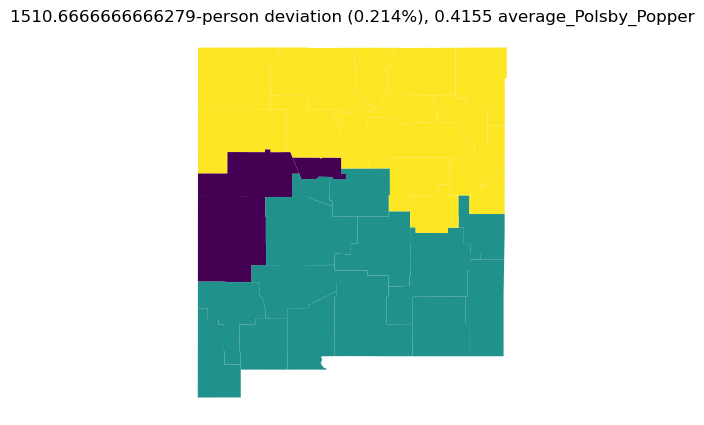

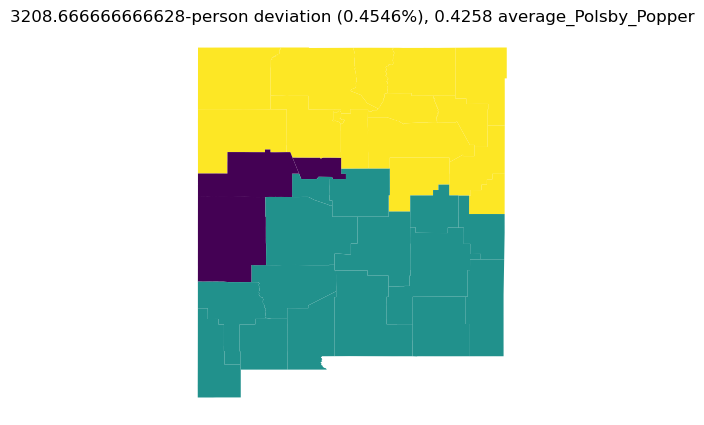

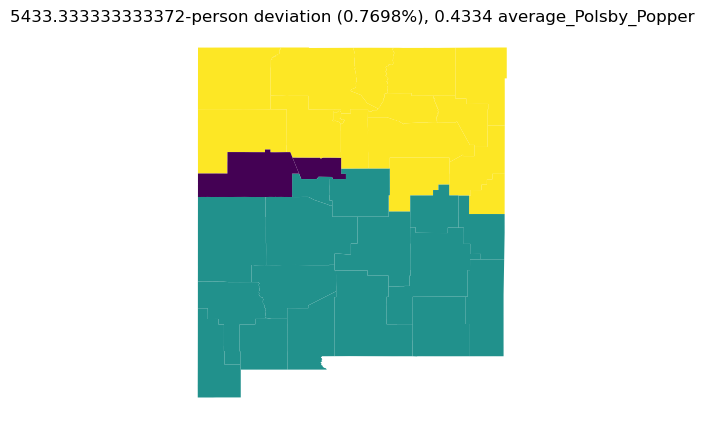

***************************************
obj_type = bottleneck_Polsby_Popper
***************************************
Pareto front objective values: [[1354.3333333333721, 0.2851744307921699], [1510.6666666666279, 0.3865841595621306]]


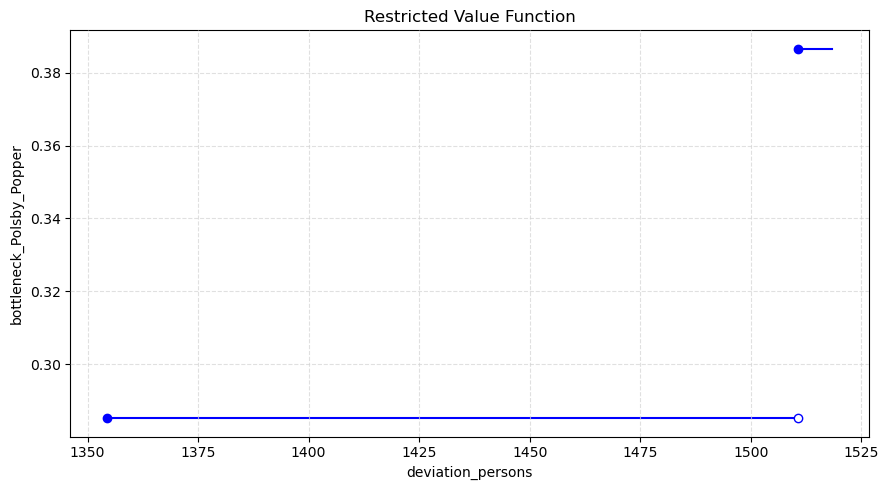

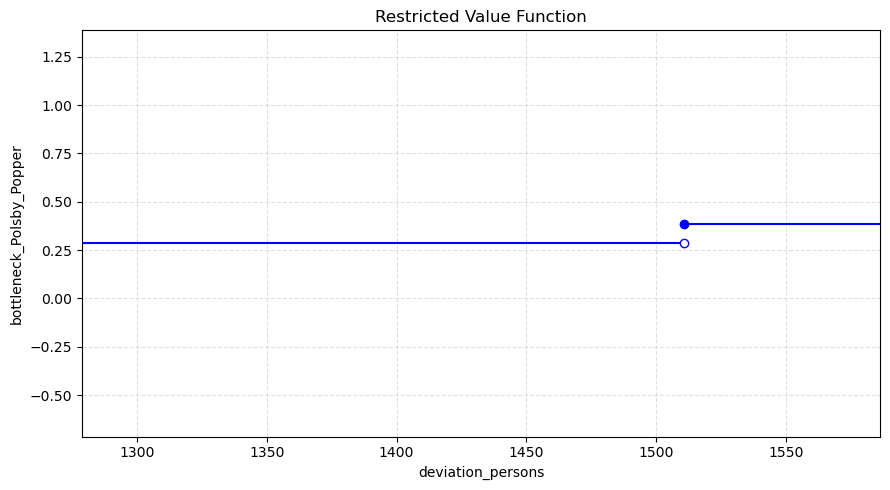

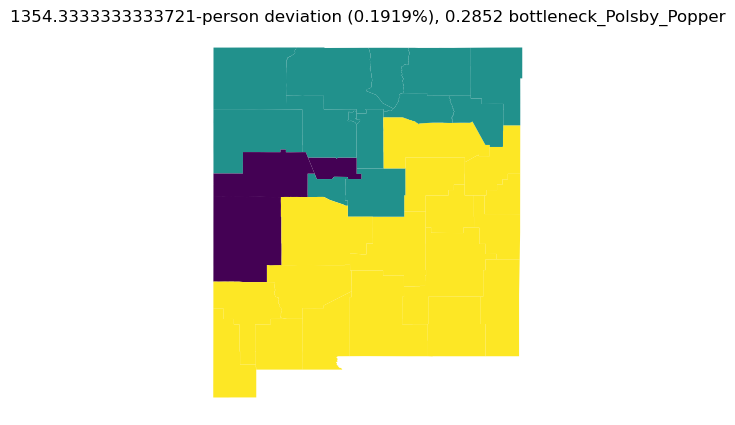

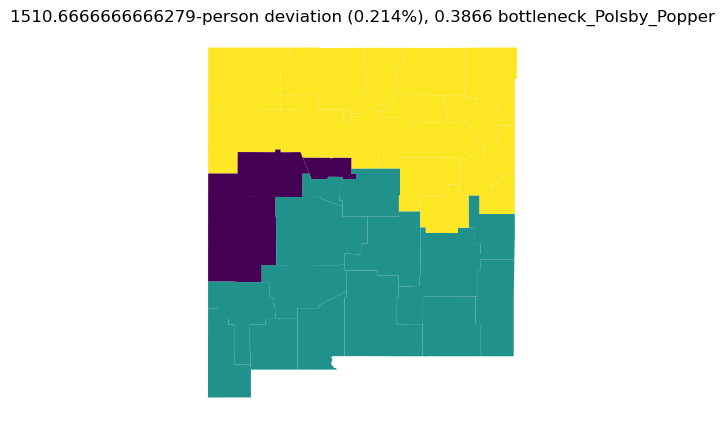

In [6]:
from pareto import ParetoFrontier
from metrics import *
from draw import draw_plan

# set dummy values... (because compute_obj checks plan feasibility...)
G._L = 0 
G._U = G._k * ideal_population
pareto = dict()

obj_types = ['cut_edges', 'perimeter', 'inverse_Polsby_Popper', 'average_Polsby_Popper', 'bottleneck_Polsby_Popper']

for obj_type in obj_types:

    print("***************************************")
    print("obj_type =", obj_type)
    print("***************************************")
    
    senses = ['min', 'max' if obj_type in ['average_Polsby_Popper', 'bottleneck_Polsby_Popper'] else 'min']
    obj_names = ['deviation_persons', obj_type]
    pareto[obj_type] = ParetoFrontier(senses, obj_names, state=state, level='county')
    
    for plan in plans:  
        dev = observed_deviation_persons(G, plan, ideal_population)
        obj = compute_obj(G, plan, obj_type)
        objs_val = [dev, obj]
        pareto[obj_type].add_plan(plan, upper_bound=objs_val)
                
    print("Pareto front objective values:", pareto[obj_type].upper_bounds)
    pareto[obj_type].tighten_lower_bounds()    
    pareto[obj_type].plot()   
    pareto[obj_type].plot_with_custom_x_ranges(method = 'heuristic', splits=None)
    
    
    pareto[obj_type].draw_plans()

In [7]:
len(plans)

149

In [8]:
for obj_type in obj_types:

    print("***************************************")
    print("obj_type =", obj_type)
    print("***************************************")
    print("Pareto front plans:", pareto[obj_type].plans)

***************************************
obj_type = cut_edges
***************************************
Pareto front plans: [[[13, 18, 25], [2, 5, 7, 8, 11, 15, 19, 21, 23, 24, 27, 30, 31], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 20, 22, 26, 28, 29, 32]], [[13, 18, 25], [2, 5, 7, 8, 11, 15, 21, 24, 29, 30, 31], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 19, 20, 22, 23, 26, 27, 28, 32]], [[13, 18, 25], [1, 3, 5, 6, 9, 10, 14, 15, 17, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 16, 19, 20, 21, 23, 24, 27, 30, 31]], [[13, 25], [2, 5, 7, 8, 11, 15, 19, 21, 23, 24, 27, 30, 31], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 18, 20, 22, 26, 28, 29, 32]], [[13, 25], [1, 3, 5, 6, 9, 10, 14, 15, 17, 18, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 16, 19, 20, 21, 23, 24, 27, 30, 31]], [[13, 25], [1, 3, 5, 6, 9, 10, 14, 15, 16, 17, 18, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 19, 20, 21, 23, 24, 27, 30, 31]]]
***************************************
obj_type = perimeter
*************************************